## **Agent-Based Modeling and Simulation Project**

+   Group Members: Romey Bajada and Aswin Subramanian Maheswaran

###  **Research Question:** 

How does social learning, compared to individual learning, influences collective knowledge acquisition under heterogeneous learning rates?


### **Objective:**

- In simple terms, we are trying to understand whether studying with peers helps students learn better than studying alone, especially when students have different learning speeds.


#### **I. Setup the environment:**

In [33]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


####    Imports and Initialization

In [34]:
# %pip install mesa networkx pandas matplotlib solara

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import functools
from dataclasses import dataclass
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns


import mesa
from mesa import Model, Agent
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from statsmodels.stats.multicomp import pairwise_tukeyhsd
 
# Visualization imports

import solara
from mesa.visualization import SolaraViz, make_plot_component
from matplotlib.patches import Rectangle
import matplotlib.lines as mlines
from mesa.visualization.components.matplotlib_components import update_counter
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


# Visualization imports

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols

In [35]:
from matplotlib.legend_handler import HandlerBase

class ImageHandler(HandlerBase):
    def __init__(self, img, zoom=0.6):
        HandlerBase.__init__(self)
        self.img = img
        self.zoom = zoom

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        im = OffsetImage(self.img, zoom=self.zoom)
        ab = AnnotationBbox(
            im,
            xy=((xdescent + width/2), (ydescent + height/2)),
            xycoords=trans,
            frameon=False,
        )
        return [ab]


In [36]:
# Learning gain constants

HOME_STUDY_GAIN = 0.0005 # small gain in studying at home. 
CLASS_GAIN = 0.005 # learning in classroom
FEEDBACK_GAIN = 0.001 # learning from feedback given by teacher
SOLO_GAIN = 0.0015 # solo study gain at a public pla
PEER_RATE = 0.05 # Peer learning rate 


### **1. Helper functions**

####    **Learning processes:**

#### a. Saturation effect:
- sat(skill) reduces learning as skill approaches a cap (e.g., 100), implementing diminishing returns.

#### b. Crowding effect:
- crowding_penalty(place) reduces learning if a library is close to or above 80% of capacity.

#### c. Social learning:
- Social learners in a library:
    - Sample one peer with higher skill (if available).
    - Gain extra learning proportional to the skill gap and a *synergy_bonus* that increases with the number of peers (with diminishing returns).
- Solo learners do not receive this peer-based bonus.

In [37]:
# Helper functions

def bound(x, lower=0.0, higher=100.0):
    """Bound a value between [lower, higher]."""
    return max(lower, min(x, higher))

def sat(skill, cap=100.0, gamma=3.5):
    """
    Saturation function: learning diminishes as skill approaches cap.
    Returns 1.0 when skill is low,
    0.0 when skill approaches cap, 
    Gamma factor controls the concavity (higher = steeper drop-off).
    """
    return max(0.0, (1.0 - (skill / cap)) ** gamma)

def crowding_penalty(place):
    """
    Add a penalty factor for crowding in public places
    Chances of distraction increase with more people. (Is there any theory behind this?)
    Returns 1.0 when empty, drops after 80% occupancy.
    """
    rho = len(place.current_learners) / max(1, place.capacity)  # occupancy ratio
    return max(0.0, 1.0 - (rho ** 1.5))

def synergy_bonus(n_peers):
    """Small collaboration with other peers gets a bonus with diminishing returns.
    Returns 0.0 when alone, saturates around 1.0 for large groups.
    """
    return np.tanh(0.5 * n_peers)  # smooth curve 0 → 1

### **2. Agent Types**

- **Student**
    - Main active agents. 
    - Each student has: 
        - A continuous skill level (initial range: 5-20)
        - An individual learning rate (heterogeneous, controlled by *learning_spread* attribute)
        - A learning mode (*social* or *solo*) : 
            - Social learners can learn from peers in *PublicPlaces*
            - Solo learners only learn individually
    
- **Teacher**
    - Has a fixed location (center of the grid)
    - Provides instruction and feedback
    - Determined by *teaching_quality* and *feedback_level*
    
- **PublicPlaces**
    - Study locations with varying resource quality and capacity. 
    - Track students studying using the *current_learners* attribute.
    - Models both crowding penalities and peer interaction effects.




####    **PublicPlaces Agent**

In [38]:
# PublicPlaces Agent

class PublicPlaces(Agent):
    """Represents study locations with varying resource quality and capacity."""
    
    def __init__(self, model, type="generic", resource_quality=0.5, capacity=7):
        super().__init__(model)
        
        self.type = type
        self.resource_quality = float(resource_quality)
        self.capacity = int(capacity)
        self.current_learners = set()
        # we'll remember the base capacity so the slider can rescale it
        self._base_capacity = self.capacity
        
    def space_left(self) -> int:
        """Remaining capacity in the public place."""
        return max(0, self.capacity - len(self.current_learners))

    def reset(self) -> None:
        """Clear out the learners for the new simulation day."""
        self.current_learners = set()
        
    def step(self):
        # places are passive — students do the action
        pass


####    **Teacher Agent**

In [39]:
# Teacher Agent

class Teacher(Agent):
    """Represents an instructor who provides teaching and feedback to students."""
    
    def __init__(self, model, teaching_quality=0.7, feedback_level=1.5):
        super().__init__(model)
        
        self.teaching_quality = float(teaching_quality)
        self.feedback_level = float(feedback_level)
        
    def step(self):
        # teacher is activated so that we can add logic later if needed
        pass




####    **Student Agent**

In [40]:
class Student(Agent):
    """
    Primary active agent represents learners with individual characteristics.
    """
    
    def __init__(self, model, learning_rate=1.0, learning_speed="social"):
        super().__init__(model)
        
        # Core attributes
        self.skill = self.model.random.uniform(5, 20)
        self.learning_rate = float(learning_rate)
        self.learning_speed = learning_speed # social or solo
        
        # tracking counters
        self.attendance = 0
        self.teacher_interactions = 0
        
    
    def step(self):
        
        # Daily learning cycle
        daily_motivation = self.model.random.uniform(0.8, 1.2)
        
        self.attend_class(daily_motivation)
        self.move_around() 
        place = self.select_study_place()
        self.prefer_study(place, daily_motivation)
        self.move_around()
        
        # Flow:
        
        # 1. Attend class (at teacher location or home)
        # 2. Wander around (random movement)
        # 3. Go to study place (purposeful movement)
        # 4. Study there (stay in place)

    
    def move_around(self):
        """Move to a neighboring cell randomly to simulate campus movement."""
        
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False
        )
        new_position = self.model.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        
    # Methods for agents
    
    # 1. Class attendance and learning from class instructions
    
    def attend_class(self, motivation=1.0):

        teacher = self.model.teachers[0]
        teaching_quality = teacher.teaching_quality

        # Skip class
        if self.model.random.random() > self.model.attendance_probability:
            gain = HOME_STUDY_GAIN * self.learning_rate * motivation * sat(self.skill)
            self.skill = bound(self.skill + gain)
            return False

        # Attend class
        self.attendance += 1
        learning_gain = (
            CLASS_GAIN * teaching_quality
            * self.learning_rate * motivation 
            * sat(self.skill) * self.model.learning_speed_multiplier
        )
        self.skill = bound(self.skill + learning_gain)

        # Enter feedback lottery - student decides whether to ask for feedback after class
        if self.model.random.random() < self.model.teacher_feedback_probability:
            self.model.feedback_requests.append(self.unique_id)

        return True

    # 2. Feedback from teachers
    
    def gain_teacher_feedback(self, teacher):
        """
        Apply feedback boost from teacher interaction. 
        """    
        self.teacher_interactions += 1
        feedback_effect = (FEEDBACK_GAIN 
            * teacher.teaching_quality 
            * teacher.feedback_level 
            * self.learning_rate 
            * self.model.learning_speed_multiplier
            * sat(self.skill)
        )
        self.skill = bound(self.skill + feedback_effect)
        
    # 3. Choosing to study in public places and learning there
    
    def select_study_place(self):
        """
        Select a public place for studying based on utility
        """
        available_spaces = []
        
        for space in self.model.study_spaces:
            if space.space_left() > 0:
                util = space.resource_quality
            
                # social learners prefer places with more people
                if self.learning_speed == "social":
                    util += 0.2
                
                # adds noise
                util += self.model.random.uniform(-0.05, 0.05)
                available_spaces.append((util, space))
                
        # 15% chance to stay at home or if no spaces available
        if not available_spaces or self.model.random.random() < 0.15:
            return None  # Study at home
        
        # Sort by utility: 80% exploitation, 20% exploration
        available_spaces.sort(key=lambda x: x[0], reverse=True)
        if self.model.random.random() > 0.2:
            chosen = available_spaces[0][1]  # Best option
        else:
            chosen = self.model.random.choice(available_spaces[:min(3, len(available_spaces))])[1]  
        
        # FIX: Safety check before accessing pos
        if chosen is None:
            return None
        
        # FIX: Ensure chosen has a position
        if not hasattr(chosen, 'pos') or chosen.pos is None:
            return None
        
        # Move student to the chosen place
        self.model.grid.move_agent(self, chosen.pos)
        
        # FIX: Use atomic operation - convert to list first if needed
        chosen.current_learners.add(self.unique_id)
        
        return chosen

    
    # 4. Simulates study session with solo or social learning
    
    def prefer_study(self, place, motivation=1.0):
        
        """Simulates study session with solo or social learning."""
        
        # Study at home
        if place is None:
            gain = HOME_STUDY_GAIN * self.learning_rate * motivation * sat(self.skill) * self.model.learning_speed_multiplier 
            self.skill = bound(self.skill + gain)
            return
        
        # FIX: Safety check
        if not hasattr(place, 'current_learners'):
            return
        
        # Base solo learning gain with crowding penalty
        crowd_factor = crowding_penalty(place)
        gain = (
            SOLO_GAIN 
            * self.learning_rate 
            * place.resource_quality 
            * self.model.learning_speed_multiplier
            * motivation 
            * sat(self.skill)
            * crowd_factor
        )
        
        # Social learning: single peer interaction
        if self.learning_speed == "social":
            # FIX: Convert set to list first to avoid "Set changed size during iteration"
            peers_here = [sid for sid in list(place.current_learners) if sid != self.unique_id]
            
            if peers_here:
                # Pick ONE peer randomly
                peer_id = self.model.random.choice(peers_here)
                peer_skill = self.model.get_agent_skill(peer_id)
                
                # Learn only if peer is stronger
                if peer_skill > self.skill:
                    gap = peer_skill - self.skill
                    synergy = synergy_bonus(len(peers_here))  
                    
                    peer_gain = (
                        PEER_RATE 
                        * (gap / 50.0) 
                        * self.learning_rate 
                        * self.model.learning_speed_multiplier 
                        * motivation 
                        * sat(self.skill)
                        * (1.0 + synergy * 0.3)  
                    )
                    gain += peer_gain
        
        self.skill = bound(self.skill + gain)
            
        

### Education model 

In [41]:
class EducationModel(Model):
    """Main simulation model for education and learning dynamics."""
    
    def __init__(
        self,
        width=20,
        height=20,
        n_students=50,
        n_teachers=1,
        n_public_places=2,
        teaching_quality=0.7,
        feedback_level=1.5,
        place_capacity_multiplier=1.0,
        learning_speed_multiplier=1.0, 
        attendance_probability=0.60,
        teacher_feedback_probability=0.45,
        social_fraction=0.5,     
        learning_spread=0.2,          
        seed=None,
    ):
        super().__init__(seed=seed)
        
        self._next_id = 0
        
        # Model parameters
        self.width = width
        self.height = height
        self.n_students = n_students
        self.place_capacity_multiplier = float(place_capacity_multiplier)
        self._last_capacity_multiplier = float(place_capacity_multiplier)
        self.learning_speed_multiplier = float(learning_speed_multiplier)  
        
        self.social_fraction = float(social_fraction)   
        self.learning_spread = float(learning_spread)               


        # Adjustable learning parameters
        self.attendance_probability = attendance_probability
        self.teacher_feedback_probability = teacher_feedback_probability

        # Grid campus
        self.grid = MultiGrid(width, height, torus=True)

        # Agent collections
        self.teachers = []
        self.students = []
        self.study_spaces = []
        self.feedback_requests = []

        # Create all agents
        self.create_public_space(n_public_places, self.place_capacity_multiplier)
        self.create_teachers(n_teachers, teaching_quality, feedback_level)
        self.create_students(n_students)

        # Setup data collection
        self._init_datacollector()
    
    def _init_datacollector(self):
        """Initialize or reinitialize the datacollector."""
        self.datacollector = DataCollector(
            model_reporters={
                "Mean_Skill": self._compute_mean_skill,
                "Mean_Skill_Social": self._compute_mean_skill_social, 
                "Mean_Skill_Solo": self._compute_mean_skill_solo,
                "Total_Attendance": self._compute_total_attendance,
                "Total_Teacher_Interactions": self._compute_total_teacher_interactions,
                "Avg_Crowding": self._compute_avg_crowding,
            },
            agent_reporters={
                "Skill": "skill",
                "Attendance": "attendance",
                "Teacher_Interactions": "teacher_interactions",
            },
        )
        
    def _compute_mean_skill(self):
        return float(np.mean([s.skill for s in self.students]))

    def _compute_total_attendance(self):
        return int(sum(s.attendance for s in self.students))

    def _compute_total_teacher_interactions(self):
        return int(sum(s.teacher_interactions for s in self.students))

    def _compute_avg_crowding(self):
        if not self.study_spaces:
            return 0.0
        crowding_values = [len(sp.current_learners) / max(1, sp.capacity) for sp in self.study_spaces]
        return float(np.mean(crowding_values))
    
    def _compute_mean_skill_social(self):
        """Compute mean skill of social-mode students."""
        social_students = [s for s in self.students if s.learning_speed == "social"]
        if not social_students:
            return 0.0
        return float(np.mean([s.skill for s in social_students]))

    def _compute_mean_skill_solo(self):
        """Compute mean skill of solo-mode students."""
        solo_students = [s for s in self.students if s.learning_speed == "solo"]
        if not solo_students:
            return 0.0
        return float(np.mean([s.skill for s in solo_students]))
    
    def next_id(self):  
        """Generate next unique agent ID."""
        current_id = self._next_id
        self._next_id += 1
        return current_id

    def create_public_space(self, n, capacity_mult):
        """Create public study spaces."""
        base_capacity = 8
        
        fixed_positions = [
            (self.width // 4, self.height // 4),
            (3 * self.width // 4, 3 * self.height // 4),
        ]
        
        for i in range(min(n, len(fixed_positions))):
            place = PublicPlaces(
                model=self,
                type="library",
                resource_quality=0.75,
                capacity=int(base_capacity * capacity_mult),
            )
            place._base_capacity = int(base_capacity * capacity_mult)
            self.study_spaces.append(place)

           
            x, y = fixed_positions[i]
            self.grid.place_agent(place, (x, y))
            
    def create_teachers(self, n, quality, feedback):
        """Create teacher agents."""
        for _ in range(n):
            t = Teacher(self, teaching_quality=quality, feedback_level=feedback)
            self.teachers.append(t)
            self.grid.place_agent(t, (self.grid.width // 2, self.grid.height // 2))

    def create_students(self, n):
        """Create student agents with diverse characteristics."""
        for _ in range(n):
            # learning-rate heterogeneity controlled by learning_spread
            low = max(0.1, 1.0 - self.learning_spread)
            high = 1.0 + self.learning_spread
            lr = self.random.uniform(0.8, 1.2)
            
            
            speed = "social" if self.random.random() < 0.5 else "solo"

            s = Student(self, lr, speed)
            self.students.append(s)

            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(s, (x, y))
        
    def get_agent_skill(self, student_id):
        """Get current skill level of student by ID."""
        for s in self.students:
            if s.unique_id == student_id:
                return s.skill
        return 0.0

    def step(self):

        if self.place_capacity_multiplier != self._last_capacity_multiplier:
            for sp in self.study_spaces:
                sp.capacity = max(1, int(sp._base_capacity * self.place_capacity_multiplier))
            self._last_capacity_multiplier = self.place_capacity_multiplier

        for place in self.study_spaces:
            place.reset()
        self.feedback_requests = []

        self.agents.shuffle_do("step")

        self.resolve_teacher_feedback()

        self.datacollector.collect(self)

    def resolve_teacher_feedback(self):
        if not self.feedback_requests or not self.teachers:
            return

        teacher = self.teachers[0]
        selected = self.random.sample(self.feedback_requests, min(5, len(self.feedback_requests)))

        for sid in selected:
            for s in self.students:
                if s.unique_id == sid:
                    s.gain_teacher_feedback(teacher)
                    break

    def reset(self):
        """Reset the model when parameters change via UI controls."""
        # Reinitialize datacollector to prevent array length mismatches
        self._init_datacollector()
       

### **2. Model Outputs**

####    The DataCollector records:

- **Model-level metrics**
    -   Mean_Skill: average student skill.
    -   Mean_Skill_Social: mean skill among social learners.
    -   Mean_Skill_Solo: mean skill among solo learners.
    -   Total_Attendance: cumulative class attendance.
    -   Total_Teacher_Interactions: total feedback events.
    -   Avg_Crowding: average occupancy ratio of public places.

- **Agent-level metrics**
    - Skill, Attendance, Teacher_Interactions for each student.

####    Interactive visualizations (via SolaraViz):

- A campus map with teacher, libraries, and students (colored by learning mode).
- A line plot of Mean_Skill_Social vs Mean_Skill_Solo over time.

In [42]:
# Visualization Components

class CampusMapRenderer:

    def __init__(self, show_grid=True, student_size=80):
        self.show_grid = show_grid
        self.student_size = student_size

        try:
            self.teacher_img = mpimg.imread('images/teacher.png')
            self.library_img = mpimg.imread('images/library.png')
        except:
            print("Warning: Could not load images")
            self.teacher_img = None
            self.library_img = None

    def render(self, ax, model) -> None:
        width, height = model.grid.width, model.grid.height
        self._setup_axes(ax, width, height)
        self._draw_places(ax, model.study_spaces)
        self._draw_teachers(ax, getattr(model, "teachers", []))
        self._draw_students(ax, getattr(model, "students", []))

        capacity = getattr(model, "place_capacity_multiplier", 1.0)
        speed = getattr(model, "learning_speed_multiplier", 1.0)
        ax.set_title(f"Campus Study Spaces (Capacity ×{capacity:.1f}, Speed ×{speed:.1f}, Step {model.steps})")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        self._draw_legend(ax)

    def _setup_axes(self, ax, width: int, height: int) -> None:
        ax.set_xlim(0, width)
        ax.set_ylim(0, height)
        ax.set_aspect("equal")
        ax.grid(self.show_grid, alpha=0.25)

    def _draw_places(self, ax, places) -> None:
        for place in places:
            try:
                x, y = place.pos
            except Exception:
                x = y = 0
            
            # Only use library image (all places are libraries now)
            if self.library_img is not None:
                img = self.library_img
                imagebox = OffsetImage(img, zoom=0.08)
                ab = AnnotationBbox(imagebox, (x + 0.5, y + 0.5), frameon=False, zorder=1)
                ax.add_artist(ab)
            else:
                # Fallback to colored rectangle
                color = "#FFC107"  # Yellow for library
                ax.add_patch(
                    Rectangle(
                        (x, y),
                        1, 1,
                        linewidth=2,
                        edgecolor="black",
                        facecolor=color,
                        alpha=0.6,
                        zorder=0,
                    )
                )
            
            # Label: occupancy
            occ = f"{len(place.current_learners)}/{place.capacity}"
            ax.text(x + 0.5, y + 0.2, occ, ha="center", va="center", 
                   fontsize=8, color="black", fontweight="bold", zorder=3,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    def _draw_teachers(self, ax, teachers) -> None:
        for t in teachers:
            try:
                x, y = t.pos
            except Exception:
                continue
            
            # Draw teacher image
            if self.teacher_img is not None:
                imagebox = OffsetImage(self.teacher_img, zoom=0.1)
                ab = AnnotationBbox(imagebox, (x + 0.5, y + 0.5), frameon=False, zorder=9)
                ax.add_artist(ab)
            
            else:
                # Fallback to star
                ax.scatter(
                    x + 0.5, y + 0.5,
                    s=160,
                    marker="*",
                    c="#1976D2",   
                    edgecolors="black",
                    linewidths=0.6,
                    zorder=9,
                    alpha=0.9,
                )

    def _draw_students(self, ax, students) -> None:
        # ALL STUDENTS SAME COLOR (no categorization)
        for s in students:
            try:
                x, y = s.pos
            except Exception:
                continue
            
            # Color based on learning mode
            if s.learning_speed == "social":
                color = "#2E7D32"  # Green for social learners
            else:  # solo
                color = "#C62828"  # Red for solo learners
            
            ax.scatter(
                x + 0.5,
                y + 0.5,
                s=self.student_size,
                c=color,
                alpha=0.8,
                edgecolors="white",
                linewidths=0.5,
                zorder=10,
            )
            
    def _draw_legend(self, ax) -> None:
        handles = []
        labels = []
        handler_map = {}
        
        # Social Student (green dot)
        
        social_h = mlines.Line2D([], [], marker="o", linestyle="None",
                             markersize=8, color="#2E7D32")
        handles.append(social_h)
        labels.append("Social Student")

        # Solo Student (red dot)
        
        solo_h = mlines.Line2D([], [], marker="o", linestyle="None",
                             markersize=8, color="#C62828")
        handles.append(solo_h)
        labels.append("Solo Student")

        # Library icon
        
        if self.library_img is not None:
            lib_h = mlines.Line2D([], [])   # dummy handle
            handles.append(lib_h)
            labels.append("Library")
            handler_map[lib_h] = ImageHandler(self.library_img, zoom=0.020)

        # Teacher Icon
        
        if self.teacher_img is not None:
            teach_h = mlines.Line2D([], [])   # dummy handle
            handles.append(teach_h)
            labels.append("Teacher")
            handler_map[teach_h] = ImageHandler(self.teacher_img, zoom=0.018)

        ax.legend(
            handles,
            labels,
            handler_map=handler_map,
            loc='upper right',
            fontsize=9,
            frameon=True
        )

@solara.component
def CampusMapView(model):
    """ Visualization function for campus map """
    update_counter.get()
    fig = plt.Figure(figsize=(8, 8))
    ax = fig.subplots()
    
    renderer = CampusMapRenderer(show_grid=True)
    renderer.render(ax, model)
    
    return solara.FigureMatplotlib(fig)

In [43]:
#  Run Visualization

#   Model params with 3 essential sliders

model_params = {
    "n_students": {
        "type": "SliderInt",
        "value": 60,
        "label": "Number of Students",
        "min": 10,
        "max": 150,
        "step": 10,
    },

    "place_capacity_multiplier": {
        "type": "SliderFloat",
        "value": 1.0,
        "label": "Study Space Capacity",
        "min": 0.5,
        "max": 2.0,
        "step": 0.1,
    },
    "learning_speed_multiplier": {
        "type": "SliderFloat",
        "value": 1.0,
        "label": "Learning Rate",
        "min": 0.5,
        "max": 2.0,
        "step": 0.1,
    },
    "attendance_probability": {
        "type": "SliderFloat",
        "value": 0.60, # 60% chance of attending class
        "label": "Attendance Probability",
        "min": 0.10,
        "max": 0.95,
        "step": 0.05,
    },
}

# Create the model
model = EducationModel(
    width=30,
    height=30,
    n_students=60,
    n_teachers=1,
    n_public_places=2, # 2 LIBRARIES 
    learning_speed_multiplier=1.0, 
    attendance_probability=0.60, 
    
)


In [44]:
@solara.component  
def SafePlotComponent(model, metric_name):
    """Plot component that handles datacollector inconsistencies."""
    update_counter.get()
    
    fig = plt.Figure(figsize=(6, 4))
    ax = fig.subplots()
    
    try:
        # Check if datacollector has data
        if not model.datacollector.model_vars or metric_name not in model.datacollector.model_vars:
            ax.text(0.5, 0.5, f'Collecting {metric_name} data...', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=11)
            return solara.FigureMatplotlib(fig)
        
        # Check array lengths before creating DataFrame
        lengths = {k: len(v) for k, v in model.datacollector.model_vars.items()}
        unique_lengths = set(lengths.values())
        
        if len(unique_lengths) > 1:
            # Length mismatch detected - DON'T clear, just show warning
            print(f"Warning: Array length mismatch detected: {lengths}")
            ax.text(0.5, 0.5, 'Data mismatch - waiting for reset...', 
                   ha='center', va='center', transform=ax.transAxes, 
                   fontsize=11, color='orange')
            return solara.FigureMatplotlib(fig)
        
        # Safe to create DataFrame
        df = model.datacollector.get_model_vars_dataframe()
        
        if df.empty:
            ax.text(0.5, 0.5, 'No data yet', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=11)
            return solara.FigureMatplotlib(fig)
        
        # Plot the data
        ax.plot(df.index, df[metric_name], linewidth=2, color='#1f77b4')
        ax.set_xlabel("Step", fontsize=10)
        ax.set_ylabel(metric_name.replace("_", " "), fontsize=10)
        ax.set_title(f"{metric_name.replace('_', ' ')}", fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.tick_params(labelsize=9)
        fig.tight_layout()
        
    except Exception as e:
        # Catch any other errors - DON'T clear datacollector
        print(f"Plot error for {metric_name}: {type(e).__name__}: {e}")
        ax.text(0.5, 0.5, f'Plot error\n{type(e).__name__}', 
               ha='center', va='center', transform=ax.transAxes, 
               fontsize=10, color='red')
    
    return solara.FigureMatplotlib(fig)


@solara.component
def SocialVsSoloPlot(model):
    """Plot component showing mean skill for social vs solo learners over time."""
    update_counter.get()
    
    fig = plt.Figure(figsize=(8, 5))
    ax = fig.subplots()
    
    try:
        # Check if datacollector has data
        if not model.datacollector.model_vars:
            ax.text(0.5, 0.5, 'Collecting data...', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=11)
            return solara.FigureMatplotlib(fig)
        
        # Check array lengths
        lengths = {k: len(v) for k, v in model.datacollector.model_vars.items()}
        unique_lengths = set(lengths.values())
        
        if len(unique_lengths) > 1:
            print(f"Warning: Array length mismatch detected: {lengths}")
            ax.text(0.5, 0.5, 'Data mismatch - waiting for reset...', 
                   ha='center', va='center', transform=ax.transAxes, 
                   fontsize=11, color='orange')
            return solara.FigureMatplotlib(fig)
        
        # Get DataFrame
        df = model.datacollector.get_model_vars_dataframe()
        
        if df.empty:
            ax.text(0.5, 0.5, 'No data yet', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=11)
            return solara.FigureMatplotlib(fig)
        
        # Check if required columns exist
        if "Mean_Skill_Social" not in df.columns or "Mean_Skill_Solo" not in df.columns:
            ax.text(0.5, 0.5, 'Waiting for group data...', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=11)
            return solara.FigureMatplotlib(fig)
        
        # Plot both lines
        ax.plot(df.index, df["Mean_Skill_Social"], 
               linewidth=2, color='#2E7D32', label='Social Learners', marker='o', markersize=3)
        ax.plot(df.index, df["Mean_Skill_Solo"], 
               linewidth=2, color='#C62828', label='Solo Learners', marker='s', markersize=3)
        
        ax.set_xlabel("Step", fontsize=11)
        ax.set_ylabel("Mean Skill", fontsize=11)
        ax.set_title("Knowledge Acquisition: Social vs Solo Learners", fontsize=12, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.tick_params(labelsize=9)
        fig.tight_layout()
        
    except Exception as e:
        print(f"Plot error: {type(e).__name__}: {e}")
        ax.text(0.5, 0.5, f'Plot error\n{type(e).__name__}', 
               ha='center', va='center', transform=ax.transAxes, 
               fontsize=10, color='red')
    
    return solara.FigureMatplotlib(fig)

In [45]:
page = SolaraViz(
    model,
    components=[
        CampusMapView,
        SocialVsSoloPlot, 
    ],
    name="Campus Learning ABM",
    model_params=model_params,
)

page

Cannot show ipywidgets in text

challenge of plot error

### **4. Experiment Design**

We run two parameter-sweep experiments using mesa.batch_run, combining descriptive statistics, visualizations, and t-tests.

### **Overview:**

- Experiment 1: Effect of social learner proportion on collective knowledge acquisition. 

- Experiment 2: Effect of learning rate heterogeneity on social vs solo learning. 






### Experiment 1 – Social Learner Proportion Sweep

#### Overview

- Tests how the **social fraction** of learners affects the collective knowledge acquisition.
- Sweeps of social_fraction from 0.0 to 1.0 (0%, 25%, 50%, 75%, 100% social learners).
- Keeps other parameters fixed (heterogeneity lr_spread=0.2, 60 students, etc.).

#### Design

-   Vary social_fraction: 0.0, 0.25, 0.5, 0.75, 1.0
    -   0.0 = all solo learners
    -   1.0 = all social learners

-   Hold other parameters fixed, e.g.:
    -   learning_spread = 0.2 (moderate heterogeneity)
    -   n_students = 60, n_public_places = 2, attendance_probability = 0.60, etc.

-   For each parameter setting:
    -   Run 10 iterations (different random seeds).
    -   Simulate for 100 steps (days).

#### Measures & Analysis:

-   For the final step of each run:
    -   Compute mean and standard deviation of Mean_Skill per social_fraction.
    -   Visualize with a boxplot of final Mean_Skill by social_fraction.
    -   Plot learning progress: average Mean_Skill over time for each social_fraction.

-   Inferential statistics:
    -   Independent-samples t-test comparing Mean_Skill for:
        -   0% social vs 100% social (social_fraction = 0.0 vs 1.0).
    - This tests whether having only social learners produces significantly different final skill levels than only solo learners.

  0%|          | 0/50 [00:00<?, ?it/s]

Experiment 1 – Mean final skill by social_fraction
   social_fraction       mean       std  count
0             0.00  12.633658  0.547484    630
1             0.25  12.541283  0.537895    630
2             0.50  12.416217  0.556245    630
3             0.75  12.914334  0.493462    630
4             1.00  12.844197  0.648379    630


<Figure size 800x500 with 0 Axes>

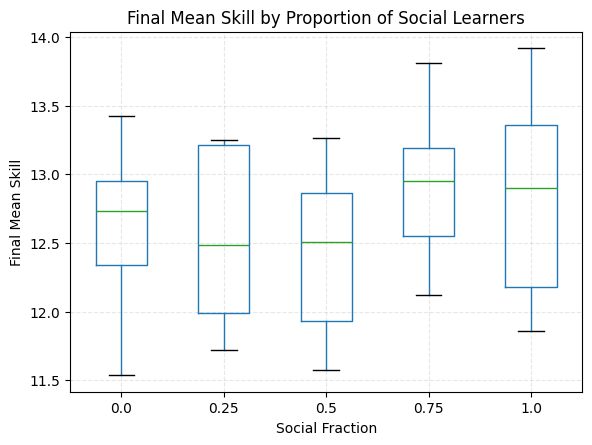

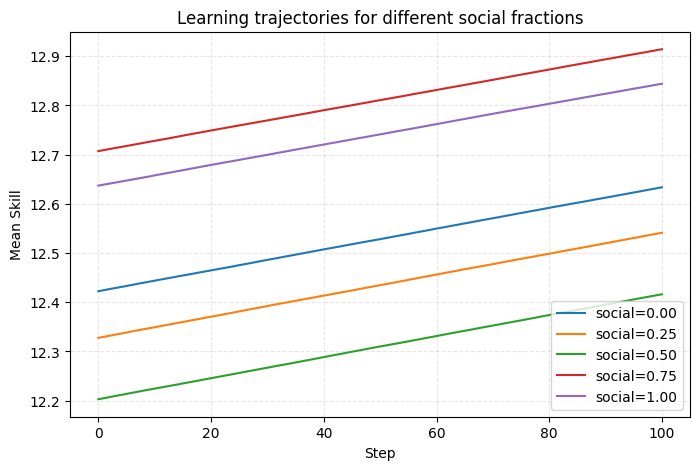


Experiment 1 – t-test 0% vs 100% social
t = -6.227, p = 0.0000
mean_0 = 12.634, mean_1 = 12.844


In [46]:
# EXPERIMENT 1: SOCIAL FRACTION

params_exp1 = {
    # keep environment fixed; sweep only social_fraction
    "social_fraction": [0.0, 0.25, 0.5, 0.75, 1.0],
    "learning_spread": [0.5],              # medium heterogeneity
    "n_students": [60],
    "n_teachers": [1],
    "n_public_places": [2],
    "place_capacity_multiplier": [1.0],
    "learning_speed_multiplier": [1.0],
    "attendance_probability": [0.60],
    "teacher_feedback_probability": [0.45],
}

results_exp1 = mesa.batch_run(
    EducationModel,
    parameters=params_exp1,
    iterations=10,          # 10 seeds per condition
    max_steps=100,          # 100 days
    data_collection_period=1,
    number_processes=1,
    display_progress=True,
)

exp1_df = pd.DataFrame(results_exp1)

# keep only final step per run
last_step = exp1_df["Step"].max()
exp1_end = exp1_df[exp1_df["Step"] == last_step].copy()

# ------------------------------
# DESCRIPTIVE STATS
# ------------------------------

# mean + sd of final Mean_Skill per social_fraction
summary_exp1 = (
    exp1_end
    .groupby("social_fraction")["Mean_Skill"]
    .agg(["mean", "std", "count"])
    .reset_index()
)
print("Experiment 1 – Mean final skill by social_fraction")
print(summary_exp1)

# boxplot of final Mean_Skill per social_fraction
plt.figure(figsize=(8, 5))
exp1_end.boxplot(column="Mean_Skill", by="social_fraction")
plt.title("Final Mean Skill by Proportion of Social Learners")
plt.suptitle("")
plt.xlabel("Social Fraction")
plt.ylabel("Final Mean Skill")
plt.grid(alpha=0.3, linestyle="--")
plt.show()

# trajectories over time (optional, but nice)
plt.figure(figsize=(8, 5))
for sf in sorted(exp1_df["social_fraction"].unique()):
    grp = exp1_df[exp1_df["social_fraction"] == sf]
    # average across runs at each step
    mean_traj = grp.groupby("Step")["Mean_Skill"].mean()
    plt.plot(mean_traj.index, mean_traj.values, label=f"social={sf:.2f}")
plt.xlabel("Step")
plt.ylabel("Mean Skill")
plt.title("Learning trajectories for different social fractions")
plt.legend()
plt.grid(alpha=0.3, linestyle="--")
plt.show()

# ------------------------------
# INFERENTIAL STATS (T-TEST)
# ------------------------------

# compare extremes: 0% social vs 100% social
group_0 = exp1_end[exp1_end["social_fraction"] == 0.0]["Mean_Skill"]
group_1 = exp1_end[exp1_end["social_fraction"] == 1.0]["Mean_Skill"]

t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)

print("\nExperiment 1 – t-test 0% vs 100% social")
print(f"t = {t_stat:.3f}, p = {p_val:.4f}")
print(f"mean_0 = {group_0.mean():.3f}, mean_1 = {group_1.mean():.3f}")

#### Experiment 1: Visualizing the runs

We track the full trajectories and the distribution of final outcomes to see how social learner share changes performance.

#### Experiment 1: What the results mean

- **Time-series plot:** Each line shows how the class learns over time at a given social fraction. Steeper lines and higher end-points mean social learning is helping. If lines flatten early, that setting runs out of new knowledge to share.
- **Boxplot:** Shows spread of final outcomes across seeds. Narrow boxes mean stable performance; wider boxes mean sensitivity to random seating/interaction patterns. If boxes rise with social_fraction, social learning is reliably better; if they overlap, the benefit is modest or uncertain.


- **Stats context:** The ANOVA and Tukey tables below tell you which social fractions differ significantly. Combine that with the plots: significant + higher medians = robust gains; overlapping boxes + non-significant tests = little to no effect.

**What we’re doing:** 
We rerun the campus model while changing only the share of social learners (0% → 100%). Each setting is run several times with different random seeds. We watch how the class’s average skill grows over time and where it ends up. If adding social learners really helps, we should see faster growth and higher final skills as the social fraction rises.


In [47]:
# convert Experiment 1 results to a DataFrame

df1 = pd.DataFrame(results_exp1)   

# ONE-WAY ANOVA: effect of social learner proportion

model = ols('Mean_Skill ~ C(social_fraction)', data=df1).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("ONE-WAY ANOVA RESULTS:")
print(anova_table)

ONE-WAY ANOVA RESULTS:
                          sum_sq        df            F  PR(>F)
C(social_fraction)  11020.111913       4.0  8687.625062     0.0
Residual            99907.372065  315045.0          NaN     NaN


In [48]:
# Tukey test

tukey = pairwise_tukeyhsd(
    endog=df1['Mean_Skill'],
    groups=df1['social_fraction'],
    alpha=0.05
)

print("\nTukey HSD Post-Hoc Test:")
print(tukey)


Tukey HSD Post-Hoc Test:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   0.0   0.25  -0.0936   0.0 -0.1022 -0.0849   True
   0.0    0.5  -0.2185   0.0 -0.2272 -0.2099   True
   0.0   0.75   0.2825   0.0  0.2739  0.2912   True
   0.0    1.0   0.2128   0.0  0.2041  0.2214   True
  0.25    0.5  -0.1249   0.0 -0.1336 -0.1163   True
  0.25   0.75   0.3761   0.0  0.3675  0.3848   True
  0.25    1.0   0.3064   0.0  0.2977   0.315   True
   0.5   0.75    0.501   0.0  0.4924  0.5097   True
   0.5    1.0   0.4313   0.0  0.4226  0.4399   True
  0.75    1.0  -0.0698   0.0 -0.0784 -0.0611   True
---------------------------------------------------
